This notebook contains bare comparison of predicted by mhcflurry binding affinities with immunogenicity. Binding affinity is a bad predictor

In [1]:
%matplotlib inline
%pylab inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from __future__ import division
from mhcflurry import predict
from mhcflurry import class1_allele_specific
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from modules.utils import coding, make_predictions

Populating the interactive namespace from numpy and matplotlib


ImportError: No module named 'mhcflurry'

In [2]:
filepath = "./data/immunogenic_peptides.txt"
if os.path.isfile(filepath):
    df = pd.read_csv(filepath, sep="\t")
    print("Reading {}".format(os.path.basename(filepath)))
else:
    print("File path is wrong")

Reading immunogenic_peptides.txt


In [3]:
df.head(2)

,Peptide,MHC,Species,Immunogenicity
0,AAFDRKSDAK,HLA-A1101,Homo,immunogenic
1,AAFEFINSL,H-2-Kb,Mus,immunogenic


In [4]:
df["Immunogenicity"].value_counts()

immunogenic        2167
non-immunogenic     341
Name: Immunogenicity, dtype: int64

In [5]:
predictions, warning_loc = make_predictions(df)

Predictions made
Number of warnings is 1
                          0
Peptide           NIRQAGVQY
MHC               HLA-B1502
Species                Homo
Immunogenicity  immunogenic


In [6]:
predictions.head(5)

,Allele,Peptide,Prediction
0,HLA-A1101,AAFDRKSDAK,367.609009
0,H-2-KB,AAFEFINSL,4.883397
0,HLA-B0801,AAHARFVAA,50.025177
0,H-2-DB,AAIGNMTLL,18.478674
0,H-2-DB,AAITIATPI,237.135712


In [7]:
true_values = coding(df["Immunogenicity"], {"immunogenic":1, "non-immunogenic":0})
true_values = pd.DataFrame(true_values)
true_values.index = range(1,len(true_values) + 1)
true_values.drop(true_values.index[warning_loc], inplace=True)
true_values["Immunogenicity"].value_counts()

1    2166
0     341
Name: Immunogenicity, dtype: int64

In [8]:
sorted_predictions = predictions["Prediction"].sort_values()
sorted_predictions.head(2)

0    1.334695
0    1.419618
Name: Prediction, dtype: float64

<function matplotlib.pyplot.show>

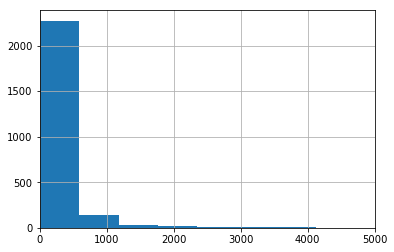

In [9]:
sorted_predictions.index = range(1,len(sorted_predictions) + 1)
plt.figure()
#plt.plot(sorted_predictions.index, sorted_predictions.values)
plot = sorted_predictions.hist(bins=50)
plot.set_xlim([0,5000])
plt.show

In [10]:
#sorted_predictions.columns = ["Prediction"]
#sorted_predictions = pd.DataFrame(sorted_predictions)
predicted_values = predictions["Prediction"]
predicted_values.index = range(1,len(predicted_values) + 1)
predicted_values.columns = ["Prediction"]
predicted_values = pd.DataFrame(predicted_values)
predicted_values["Prediction"] = np.where(predicted_values["Prediction"] <= 500, 1, 0)
predicted_values["Prediction"].value_counts()

1    2218
0     289
Name: Prediction, dtype: int64

In [11]:
accuracy_score(true_values, predicted_values)

0.8165137614678899

In [12]:
roc_auc_score(true_values, predicted_values)

0.57754201834266172

In [13]:
confusion_matrix(true_values, predicted_values, labels=[0,1])


array([[  85,  256],
       [ 204, 1962]])

In [14]:
fn = 256/2507
fn

0.1021140805743917

In [15]:
i = 0
probabilities = []
for x, y in zip(true_values["Immunogenicity"], predicted_values["Prediction"]):
    if x == y:
        i += 1
    probabilities.append(i/len(true_values))

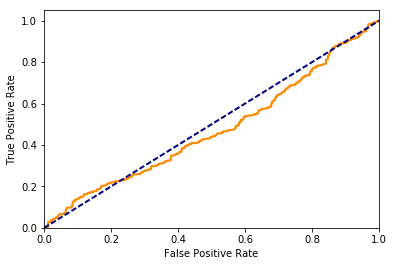

In [16]:
fpr, tpr, thresholds = roc_curve(true_values, probabilities, pos_label=1)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()